# Experiment 2
Adjust the size of dataset (valid set) to see what happens to the performance of various calibration models

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
import importlib
from pprint import pprint
import numpy as np
import pandas as pd
from typing import Iterable

In [3]:
from probcalkge import Experiment, DatasetWrapper, ExperimentResult
from probcalkge import get_datasets, get_calibrators, get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error

In [4]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
def dataset_stats(ds: Iterable[DatasetWrapper]) -> pd.DataFrame:
    vals = []
    rows = []
    cols = ['train', 'valid', 'test', 'entities', 'relations']
    for i in ds:
        rows.append(i.name)
        vals.append(i.stats)
    return pd.DataFrame(vals, index=rows, columns=cols)

In [6]:
df = dataset_stats(ds)
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   train &   valid &    test &  entities &  relations \\
\midrule
FB13k      &  316232 &   11816 &   47464 &     75043 &         13 \\
WN11       &  110361 &    4877 &   19706 &     38194 &         11 \\
YAGO39     &  354994 &   18471 &   18507 &     37612 &         37 \\
DBpedia50  &   32388 &     246 &    4196 &     24624 &        351 \\
UMLS       &    5216 &    1304 &    1322 &       135 &         46 \\
Kinship    &    8544 &    2136 &    2148 &       104 &         25 \\
Nations    &    1592 &     398 &     402 &        14 &         55 \\
YAGO\_ET    &  364810 &   50194 &   49268 &     26957 &         64 \\
DBpedia\_ET &  653188 &  104776 &  104900 &     99240 &        316 \\
\bottomrule
\end{tabular}



In [7]:
import random
from probcalkge import DatasetWrapper

def shrink_dataset(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    '''
    Shrink the size of dataset training samples by randon sampling
    '''
    new_X_train = random.sample(ds.X_train.tolist(), int(perc * len(ds.X_train)))
    new_X_train = np.array(new_X_train)
    new_X_ents = set(new_X_train[:, 0]).union(set(new_X_train[:, 2]))
    new_X_rels = set(new_X_train[:, 1])

    new_X_valid, new_y_valid = [], []
    for X, y in zip(ds.X_valid, ds.y_valid):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_valid.append(X.tolist())
            new_y_valid.append(y)
    new_X_valid, new_y_valid = np.array(new_X_valid), np.array(new_y_valid)
    
    new_X_test, new_y_test = [], []
    for X, y in zip(ds.X_test, ds.y_test):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_test.append(X.tolist())
            new_y_test.append(y)
    new_X_test, new_y_test = np.array(new_X_test), np.array(new_y_test)

    return DatasetWrapper(f'{ds.name}',
                            new_X_train,
                            new_X_valid, new_y_valid,
                            new_X_test, new_y_test
    )

def shrink_valid(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    valids = np.hstack([ds.X_valid, ds.y_valid.reshape([-1, 1])])
    new_valids = np.array(random.sample(valids.tolist(), int(perc * len(valids))))
    return DatasetWrapper(f'{ds.name}',
                            ds.X_train,
                            new_valids[:, :3], new_valids[:, 3].astype(int),
                            ds.X_test, ds.y_test
    )


In [8]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error]
)

exp.load_trained_kges('../saved_models/')

exp_reses = []

for i in (1.0, 0.7, 0.4, 0.1, 0.05, 0.01):
    new_fb = shrink_valid(ds.fb13, perc=i)
    new_wn = shrink_valid(ds.wn18, perc=i)
    new_yg = shrink_valid(ds.yago39, perc=i) 
    
    exp.datasets = [new_fb, new_wn, new_yg]
    
    exp_res = exp.run_with_trained_kges()
    # exp_res = exp.run()
    # exp.save_trained_kges(f'../saved_models/shrink-{i}/')
    exp_reses.append(exp_res)
    # newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])



Loaded models:
{'DBpedia50': OrderedDict([('ComplEx',
                            <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E8634C99C8>),
                           ('DistMult',
                            <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001E85F980048>),
                           ('HolE',
                            <ampligraph.latent_features.models.HolE.HolE object at 0x000001E85FC80048>),
                           ('TransE',
                            <ampligraph.latent_features.models.TransE.TransE object at 0x000001E869CD7048>)]),
 'DBpedia_ET': OrderedDict([('ComplEx',
                             <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000001E85FACA048>),
                            ('DistMult',
                             <ampligraph.latent_features.models.DistMult.DistMult object at 0x000001E864C3F048>),
                            ('TransE',
                             <ampligraph.laten

In [9]:
def res_pivot(exp_res: ExperimentResult) -> pd.DataFrame:
    newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])
    newdf['avg_excl_uncal'] = newdf.loc[:, newdf.columns != 'UncalCalibrator'].mean(axis=1)
    return newdf

In [13]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).idxmin(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=('100%', '70%', '40%', '10%', '5%', '1%'))
various_counts['UncalCalibrator'] = pd.Series([0, 0, 0, 0, 0, 0], index=('100%', '70%', '40%', '10%', '5%', '1%'))
lgds = ['UncalCalibrator', 'PlattCalibrator', 'IsotonicCalibrator', 'BetaCalibrator', 'HistogramBinningCalibrator']
various_counts = various_counts.reindex(columns=lgds)

[Text(0.5, 0, 'scale'), Text(0, 0.5, 'winning counts')]

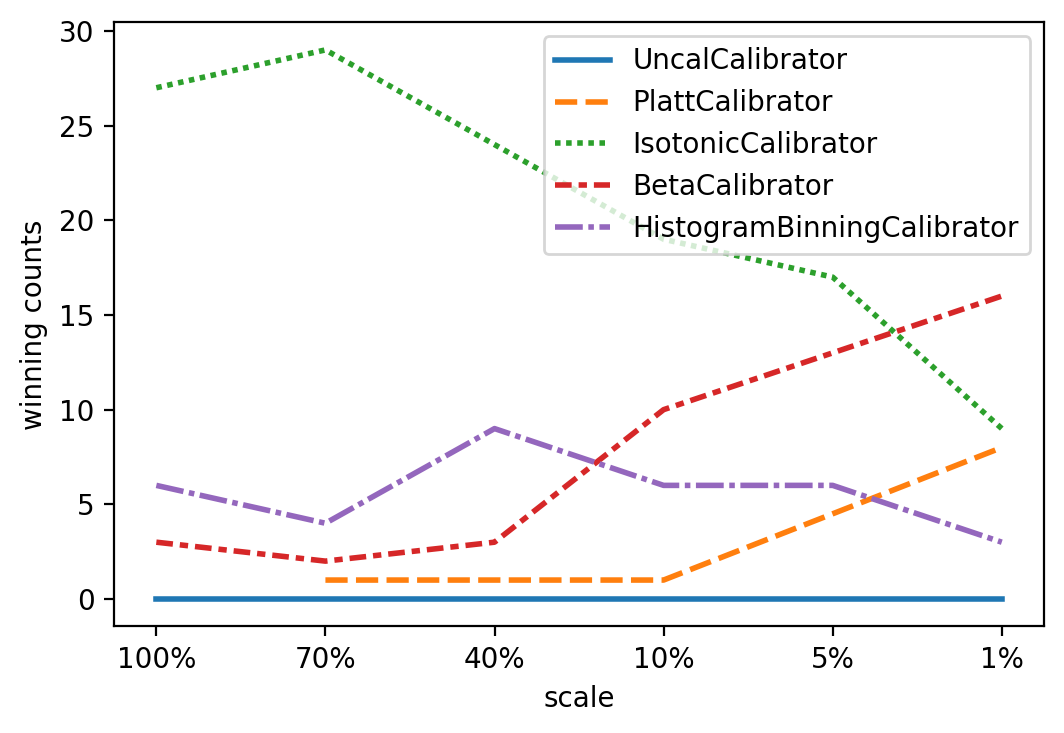

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200 # default for me was 75
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

import seaborn as sns
ax = sns.lineplot(data=various_counts, sort=False)
ax.set(xlabel='scale', ylabel='winning counts')

In [12]:
various_counts

,BetaCalibrator,IsotonicCalibrator,PlattCalibrator,HistogramBinningCalibrator,UncalCalibrator
100%,3.0,27.0,NaN,6.0,0
70%,2.0,29.0,1.0,4.0,0
40%,3.0,24.0,NaN,9.0,0
10%,10.0,19.0,1.0,6.0,0
5%,13.0,17.0,NaN,6.0,0
1%,16.0,9.0,8.0,3.0,0
